In [12]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
import seaborn as sns
import robust_loss_pytorch.general
from sklearn.preprocessing import scale as scaler
import numpy.random as npr
from robust_loss_pytorch import distribution
import random
import torch.nn as nn
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsRegressor

# Construct some regression data with some extreme outliers.
np.random.seed(1234)
torch.manual_seed(1234)

class RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(1, 1)
    def forward(self, x): 
        return self.linear(x[:,None])[:,0]
    
class Poly2RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(Poly2RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(2, 1)
    def forward(self, x): 
        x = torch.cat([(x**2).view(-1,1), x.view(-1,1)], axis=1)
        return self.linear(x)[:,0]
    
class Poly4RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(Poly4RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(4, 1)
    def forward(self, x): 
        x = torch.cat([(x**4).view(-1,1), (x**3).view(-1,1), (x**2).view(-1,1), x.view(-1,1)], axis=1)
        return self.linear(x)[:,0]


def plot_regression(regression, u=None, c=None):
    # A helper function for plotting a regression module.
    x_plot = np.linspace(min(x), max(x), 500)
    if c is None:
        y_plot = regression(torch.Tensor(x_plot)).detach().numpy()
    else:
        y_plot = regression(torch.Tensor(x_plot), c).detach().numpy()
#     y_plot_true = x_plot * scale_true + shift_true
    
    plt.figure(0, figsize=(4,4))
    if u is not None:
        sns.scatterplot(x, y, hue=U)
    else:
        sns.scatterplot(x, y)
#     plt.plot(x_plot, y_plot_true, color='k')
    plt.plot(x_plot, y_plot, color='navy', label='regressor')
    plt.legend()

# Heteroskedastic data

/Users/kentatakatsu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


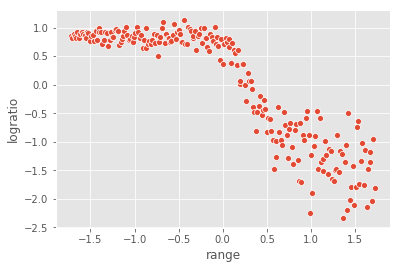

In [13]:
X = pd.read_csv('../dataset/lidar.tsv', sep='  ')
x_range = X['range']
y_ratio = X['logratio']
x_range = (x_range-np.mean(x_range))/np.std(x_range)
y_ratio = (y_ratio-np.mean(y_ratio))/np.std(y_ratio)
sns.scatterplot(x_range, y_ratio)

## Linear regression with Adaptive Roust loss

0   : loss=1.050866  alpha=1.998010  scale=0.993690

MSE: 0.217280


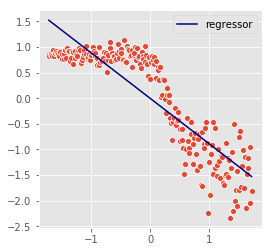

In [14]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_range)
y = torch.Tensor(y_ratio)

hetero_alpha = []
hetero_scale = []
for epoch in tqdm(range(500)): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 
    hetero_alpha.append(adaptive.alpha()[0,0].data.numpy())
    hetero_scale.append(adaptive.scale()[0,0].data.numpy())

# It fits!
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))

0   : loss=1.699972  alpha=1.997990  scale=1.006333

MSE: 0.149405


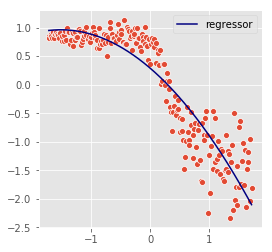

In [15]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = Poly2RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_range)
y = torch.Tensor(y_ratio)

hetero_alpha = []
hetero_scale = []
for epoch in tqdm(range(500)): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 
    hetero_alpha.append(adaptive.alpha()[0,0].data.numpy())
    hetero_scale.append(adaptive.scale()[0,0].data.numpy())

# It fits!
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))

0   : loss=1.393505  alpha=1.998010  scale=0.993690

MSE: 0.095241


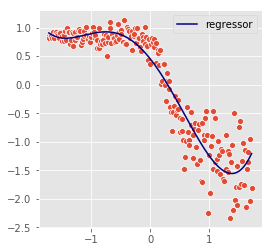

In [16]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = Poly4RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_range)
y = torch.Tensor(y_ratio)

hetero_alpha = []
hetero_scale = []
for epoch in tqdm(range(500)): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 
    hetero_alpha.append(adaptive.alpha()[0,0].data.numpy())
    hetero_scale.append(adaptive.scale()[0,0].data.numpy())

# It fits!
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))